In [3]:
import zipfile
z = zipfile.ZipFile("archive.zip")
z.extractall()

In [17]:
pip install opencv-python-headless


   ---------------------------------------- 0.0/39.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.4 MB 435.7 kB/s eta 0:01:31
   ---------------------------------------- 0.1/39.4 MB 648.1 kB/s eta 0:01:01
   ---------------------------------------- 0.2/39.4 MB 1.2 MB/s eta 0:00:32
   ---------------------------------------- 0.5/39.4 MB 2.3 MB/s eta 0:00:17
    --------------------------------------- 0.9/39.4 MB 3.8 MB/s eta 0:00:11
   - -------------------------------------- 1.1/39.4 MB 3.8 MB/s eta 0:00:10
   - -------------------------------------- 1.3/39.4 MB 3.8 MB/s eta 0:00:10
   - -------------------------------------- 1.4/39.4 MB 4.0 MB/s eta 0:00:10
   - -------------------------------------- 1.4/39.4 MB 4.0 MB/s eta 0:00:10
   - -------------------------------------- 1.4/39.4 MB 4.0 MB/s eta 0:00:10
   - -------------------------------------- 1.5/39.4 MB 2.9 MB/s eta 0:00:14
   - ---

In [19]:
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [43]:
import numpy as np

def get_data(data_dir):
    labels = ['PNEUMONIA', 'NORMAL']  # Example labels
    images = []  # List to store image arrays
    image_labels = []  # List to store corresponding labels

    for label in labels:
        path = os.path.join(data_dir, label)
        if not os.path.exists(path):
            print(f"Path does not exist: {path}")
            continue  # Skip if path is invalid

        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is not None:  # Check if image was loaded successfully
                    images.append(img_arr)  # Add image to the list
                    image_labels.append(class_num)  # Add corresponding label
                else:
                    print(f"Failed to read image: {os.path.join(path, img)}")
            except Exception as e:
                print(f"Error processing file: {img}, {e}")

    # Convert lists to NumPy arrays
    images = np.array(images, dtype=object)  # Use `dtype=object` for varying shapes
    image_labels = np.array(image_labels)  # Labels will have uniform shape

    return images, image_labels

In [46]:
train_images, train_labels = get_data("chest_xray/train")
test_images, test_labels = get_data("chest_xray/test")
val_images, val_labels = get_data("chest_xray/val")

In [50]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
penomina_dir = "chest_xray/train/PNEUMONIA"

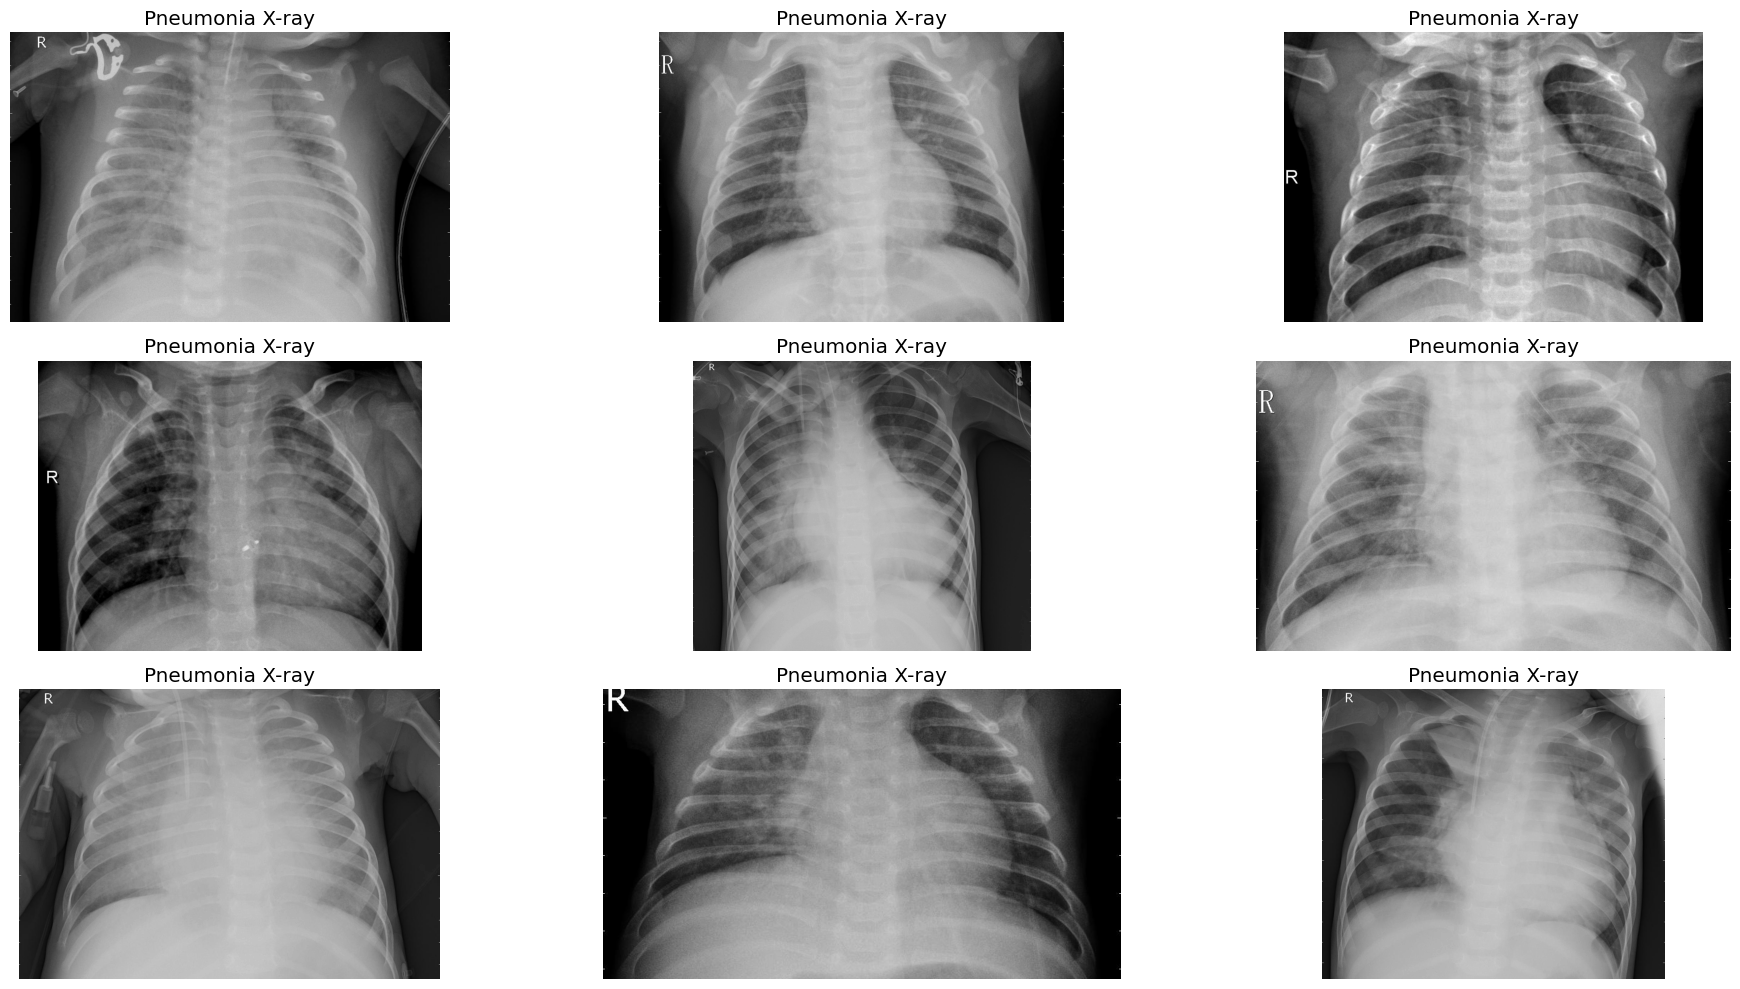

In [52]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(penomina_dir , pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout()

In [54]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

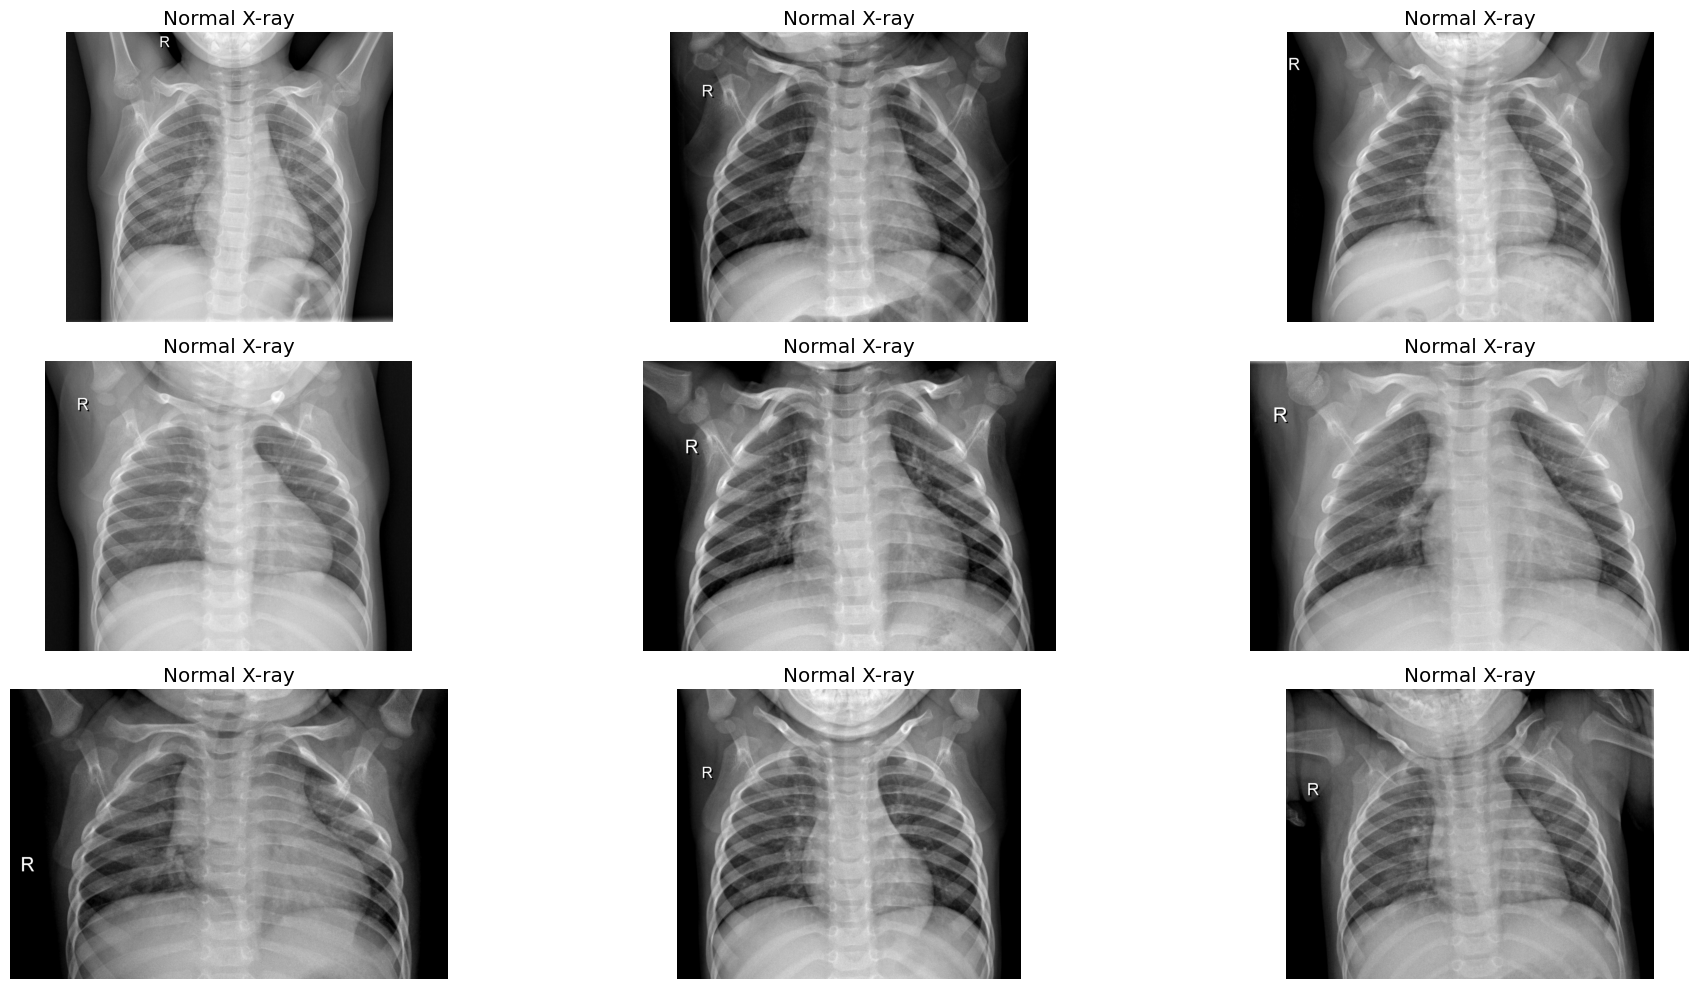

In [56]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
plt.tight_layout()

In [68]:
import seaborn as sns


<Axes: xlabel='count'>

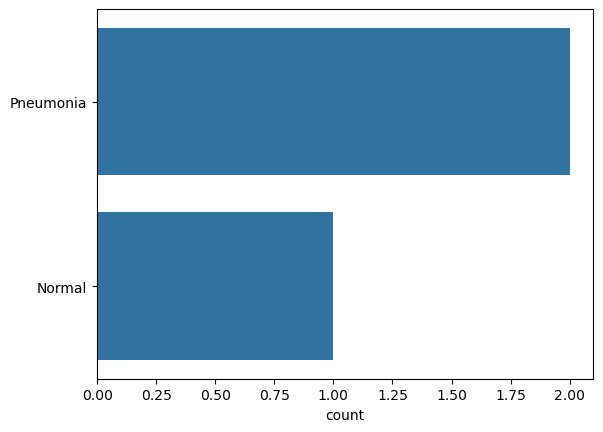

In [70]:
# Example definition of train
train = [
    ["image1.jpg", 0],
    ["image2.jpg", 1],
    ["image3.jpg", 0],
]
listx = []
for i in train:
    if(i[1] == 0):
        listx.append("Pneumonia")
    else:
        listx.append("Normal")
sns.countplot(listx)





In [72]:
# Data Augmentation & Resizing

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:
train_datagen = ImageDataGenerator(rescale = 1. / 255, 
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode="nearest")
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
train_generator = train_datagen.flow_from_directory("chest_xray/train",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')
valid_generator = valid_datagen.flow_from_directory("chest_xray/val",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [7]:
class_labels = train_generator.class_indices

In [9]:
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [11]:
class_name = {value:key for (key, value) in class_labels.items()}

In [13]:
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [15]:
# VGG19 CNN Architecture

In [17]:
base_model = VGG19(input_shape = (128,128,3),
                     include_top = False,
                     weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.inputs, output)
model_01.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [1]:
!pip install Pillow


In [2]:
from PIL import Image


In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

filepath = "model.h5"
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
cp = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False, mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)


In [23]:
# 1. Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 2. Define the model
model_01 = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # Replace 3 with your actual number of classes
])

# 3. Callbacks (optional)
filepath = "model.h5"
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
cp = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, mode="auto")
lrr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)

# 4. Optimizer (no decay)
sgd = SGD(learning_rate=0.0001, momentum=0.0, nesterov=True)

# 5. Compile the model
model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [27]:
train_dir = "chest_xray/train"   # ✅ Replace with your actual path
val_dir = "chest_xray/val"       # ✅ Replace with your actual path

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

valid_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [29]:
print("Classes found:", train_generator.class_indices)
print("Number of classes:", train_generator.num_classes)


Classes found: {'NORMAL': 0, 'PNEUMONIA': 1}
Number of classes: 2


In [31]:
Dense(train_generator.num_classes, activation='softmax')

<Dense name=dense_9, built=False>

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

model_01 = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')  
])


In [67]:
from tensorflow.keras.optimizers import SGD

sgd = SGD(learning_rate=0.0001, momentum=0.0, nesterov=True)

model_01.compile(
    loss="categorical_crossentropy",
    optimizer=sgd,
    metrics=["accuracy"]
)


In [69]:
history_01 = model_01.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=1,
    callbacks=[es, cp, lrr],
    validation_data=valid_generator,
    verbose=1
)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.6856 - loss: 0.6093

50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 845ms/step - accuracy: 0.6864 - loss: 0.6089 - val_accuracy: 0.5000 - val_loss: 0.7703 - learning_rate: 1.0000e-04


In [87]:
import os

# Check and create the directory if it doesn't exist
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")

# Save the full model (architecture + weights)
model_01.save("model_weights/vgg19_model_01.h5", overwrite=True)


In [104]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test generator
test_generator = test_datagen.flow_from_directory(
    "chest_xray/test",
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True,
    seed=42,
    color_mode='rgb'
)


Found 624 images belonging to 2 classes.


In [106]:
model_01.load_weights("model_weights/vgg19_model_01.h5")

vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.5000 - loss: 0.7703
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 562ms/step - accuracy: 0.6308 - loss: 0.6656


In [108]:
print(f"Validation Loss: {vgg_val_eval_01[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_01[1]}")
print(f"Test Loss: {vgg_test_eval_01[0]}")
print(f"Test Accuarcy: {vgg_test_eval_01[1]}")

Validation Loss: 0.770271897315979
Validation Accuarcy: 0.5
Test Loss: 0.6685450673103333
Test Accuarcy: 0.625


In [12]:
# Increamental unfreezing & fine tuning


In [8]:
import tensorflow as tf  # ✅ Required import

# Load the base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

# Get all layer names
base_model_layer_names = [layer.name for layer in base_model.layers]

print(base_model_layer_names)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
['input_layer', 'Conv1', 'bn_Conv1', 'Conv1_relu', 'expanded_conv_depthwise', 'expanded_conv_depthwise_BN', 'expanded_conv_depthwise_relu', 'expanded_conv_project', 'expanded_conv_project_BN', 'block_1_expand', 'block_1_expand_BN', 'block_1_expand_relu', 'block_1_pad', 'block_1_depthwise', 'block_1_depthwise_BN', 'block_1_depthwise_relu', 'block_1_project', 'block_1_project_BN', 'block_2_expand', 'block_2_expand_BN', 'block_2_expand_relu', 'block_2_depthwise', 'block_2_depthwise_BN', 'block_2_depthwise_relu', 'block_2_project', 'block_2_project_BN', 'block_2_add', 'block_3_expand', 'block_3_expand_BN', 'block_3_expand_relu', 'block_3_pad', 'block_3_depthwise', 'block_3_depthwise_BN', 'block_3_depthwise_relu', 'block_3_project', 'block_3_project_BN', 'block_4_expand', 'block_4_expand_BN', 'block_4_expand_relu', 'block_4_depthwise', 'block_4_depthwise_BN', 'block_4_depthwise_relu', 'block_4_project', 'block_4_project_BN', 'block_4_add', 'b

In [36]:
from tensorflow.keras.optimizers import SGD

# Define optimizer
sgd = SGD(learning_rate=0.0001, momentum=0.0, nesterov=True)

# Compile the model
model_02.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])


In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [42]:
train_dir = "chest_xray/train"
valid_dir = "chest_xray/val"

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [46]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [48]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Model Checkpoint
cp = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Learning Rate Reduction
lrr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# 1. Define Model Architecture
model = Sequential([
    InputLayer(input_shape=(224, 224, 3)),  # Adjust input size here
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Change according to your task
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 2. Prepare Data Generators with Resizing
target_size = (224, 224)  # Resized input shape

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'chest_xray/train',
    target_size=target_size,
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    'chest_xray/val',
    target_size=target_size,
    batch_size=32,
    class_mode='binary'
)

# 3. Define Callbacks
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cp = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
lrr = LearningRateScheduler(lambda epoch: 1e-3 * 0.9 ** epoch)

# 4. Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=1,
    callbacks=[es, cp, lrr],
    validation_data=valid_generator,
    validation_steps=5
)


C:\Users\gungu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5927 - loss: 1.7694

C:\Users\gungu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5976 - loss: 1.7410 - val_accuracy: 0.5625 - val_loss: 0.5755 - learning_rate: 0.0010


In [76]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

input_shape = (224, 224, 3)  # FIXED SHAPE

# Load VGG19 base
base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # For binary classification

# Final model
model_02 = Model(inputs=base_model.input, outputs=predictions)

# Compile
model_02.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [78]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

target_size = (224,224)

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'chest_xray/train',
    target_size=target_size,
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    'chest_xray/val',
    target_size=target_size,
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    'chest_xray/test',
    target_size=target_size,
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [87]:
model_02.save("model_weights/vgg19_model_02.h5")


In [91]:
from tensorflow.keras.optimizers import Adam

model_02.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',      # or 'categorical_crossentropy' if multiclass
    metrics=['accuracy']
)


In [93]:
history_02 = model_02.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=5
)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step - accuracy: 0.4730 - loss: 0.7554 - val_accuracy: 0.5000 - val_loss: 0.7254
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.6882 - loss: 0.6127 - val_accuracy: 0.5000 - val_loss: 0.7820
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 61s 6s/step - accuracy: 0.6896 - loss: 0.6082 - val_accuracy: 0.5000 - val_loss: 0.8246
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.6780 - loss: 0.6684 - val_accuracy: 0.5000 - val_loss: 0.8228
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.7378 - loss: 0.5998 - val_accuracy: 0.5000 - val_loss: 0.8196
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - accuracy: 0.7362 - loss: 0.5459 - val_accuracy: 0.5000 - val_loss: 0.8290
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.7287 - loss: 0.5677 - val_accuracy: 0.5000 - val_loss: 0.8257
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.7743 - loss: 0.5403 - val_accuracy: 0.5000 - val_loss:

In [97]:
val_loss, val_accuracy = model_02.evaluate(valid_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.4375 - loss: 0.7215
Validation Loss: 0.7214791774749756
Validation Accuracy: 0.4375


In [99]:
# Unfreezing and fine tuning the entire network


In [105]:
from tensorflow.keras.models import load_model
model = load_model("model_weights/vgg19_model_01.h5")
model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │    25,233,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,234,500 (96.26 MB)

 Trainable params: 25,234,498 (96.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [109]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0.0, nesterov = True)

model_03.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [114]:
import tensorflow as tf

# Enable eager execution for all regular functions
tf.config.run_functions_eagerly(True)

# Enable eager execution specifically for tf.data pipelines (like generators)
tf.data.experimental.enable_debug_mode()


In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)  # Ensures eager execution

model_02.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_03 = model_02.fit(
    train_generator, 
    steps_per_epoch=100,
    epochs=1, 
    callbacks=[es, cp, lrr],
    validation_data=valid_generator
)


 26/100 ━━━━━━━━━━━━━━━━━━━━ 32:53 27s/step - accuracy: 0.8768 - loss: 0.2948

In [ ]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_02.save(filepath = "model_weights/vgg_unfrozen.h5", overwrite=True)